# Соответствие изображения описанию

## Описание задачи

Вы работаете в фотохостинге для профессиональных фотографов "Со Смыслом" ("With Sense").

Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии

![image](2023-08-09-14-00-49.jpg)  
описание выглядит так:

*A hiker poses for a picture in front of stunning mountains and clouds.*

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:

*A man is crossing a mountain pass on a metal bridge.*

Сервис выводит несколько фотографий с такой же или похожей сценой.

![image](2023-08-09-14-00-50.jpg)

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

- Разработать демонстрационную версию поиска изображений по запросу
- Обучить модель, которая получит векторное представление изображения и текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу

## Описание данных

Для обучения
- `train_images/` — папка, изображения для тренировки модели
- `train_dataset.csv` — данные для обучения
  - имя файла изображения
  - идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`
  - текст описания
  - для одной картинки может быть доступно до 5 описаний
- `crowd_annotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга
  - 1 колонка — имя файла изображения
  - 2 колонка — идентификатор описания
  - 3 колонка — доля людей, подтвердивших, что описание соответствует изображению
  - 4 колонка — количество человек, подтвердивших, что описание соответствует изображению
  - 5 колонка — количество человек, подтвердивших, что описание не соответствует изображению
- `expert_annotations.tsv` — данные по соответствию изображения и описания, полученные в результате опроса экспертов
  - 1 колонка — имя файла изображения
  - 2 колонка — идентификатор описания
  - 3, 4, 5 колонка — оценка экспертов от 1 до 4, где
    - 1 — изображение и запрос совершенно не соответствуют друг другу
    - 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует
    - 3 — запрос и текст соответствуют с точностью до некоторых деталей
    - 4 — запрос и текст соответствуют полностью

Для тестирования
- `test_images/` — папка, изображения для тестирования модели
- `test_queries.csv` — данные для тестирования
  - для одной картинки может быть доступно до 5 описаний
    - идентификатор запроса — в формате `<имя файла изображения>#<порядковый номер описания>`
    - текст запроса
    - релевантное изображение — имя файла

## Описание задачи в терминах МО

Регрессия по оценке соответствия объединённого векторного представлению изображения и текста.  
Задача — Совместный поиск на основе изображений и текста (Joint image-text based retrieval)

Метрика — RMSE  
Функция потерь — MSE

## Подключение библиотек

In [ ]:
# !pip install keras-nlp --upgrade --user
# !pip install livelossplot

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

import keras_nlp
import tensorflow as tf

from tqdm import tqdm

from pathlib import Path

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression

from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import image_dataset_from_directory, load_img
from keras.applications.resnet import ResNet50
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from IPython.display import display, Markdown
from PIL import Image

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from livelossplot import PlotLossesKeras

# Выбран фреймворк Keras

Using TensorFlow backend


In [ ]:
RANDOM_STATE = 12345

def image_examples(image_filename: pd.Series, title: pd.Series, base_path):
    fig = plt.figure(figsize=(10, 4))
    for i in range(image_filename.shape[0]):
        fig.add_subplot(math.ceil(image_filename.shape[0]/4), 4, i+1)
        plt.imshow(Image.open(Path(base_path, image_filename.iloc[i])))
        plt.title(title.iloc[i][:16]+'...')
        plt.xticks([])
        plt.yticks([])
    plt.show();

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dimka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Получение данных

In [ ]:
# Пути к папкам с изображениями
train_images_path = './data/train_images/'
test_images_path = './data/test_images/'

# Пути к файлам
train_dataset_path = './data/train_dataset.csv'
crowd_annotations_path = './data/crowd_annotations.tsv'
expert_annotations_path = './data/expert_annotations.tsv'

test_queries_path = './data/test_queries.csv'

In [ ]:
train_dataset = pd.read_csv(train_dataset_path)
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
# Датасеты только для просмотра изображений, для подготовки и обучения будут ниже
train_datagen = ImageDataGenerator(
    rescale=1/255
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='image',
    y_col='query_text',
    directory=train_images_path,
    batch_size=32,
    seed=RANDOM_STATE
)

Found 5822 validated image filenames belonging to 977 classes.


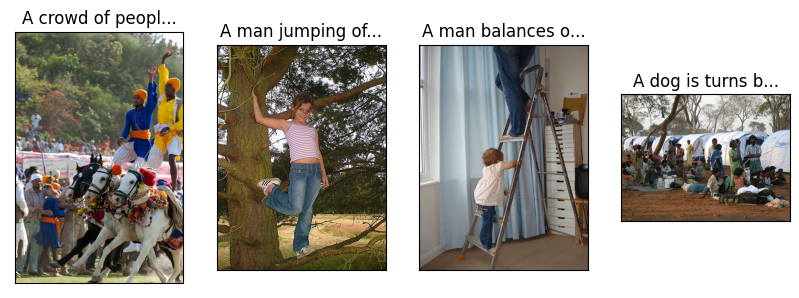

In [ ]:
sample = train_dataset.sample(4, random_state=RANDOM_STATE)
image_examples(sample['image'], sample['query_text'], train_images_path)

In [ ]:
crowd_annotations = pd.read_csv(
    crowd_annotations_path, sep='\t', header=None,
    names=['image', 'query_id', 'ratio', 'match', 'not_match']
)
expert_annotations = pd.read_csv(
    expert_annotations_path, sep='\t', header=None,
    names=['image', 'query_id', 'score_1', 'score_2', 'score_3']
)

display(crowd_annotations.head())
display(expert_annotations.head())

image                     query_id  ratio  match  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0      3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0      0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    0.0      0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    0.0      0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    0.0      0   

   not_match  
0          0  
1          3  
2          3  
3          3  
4          3

image                     query_id  score_1  score_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   score_3  
0        1  
1        2  
2        2  
3        2  
4        2

In [ ]:
test_dataset = pd.read_csv(test_queries_path, sep='|', index_col=0)
test_dataset.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='image',
    y_col='query_text',
    directory=test_images_path,
    batch_size=32,
    seed=RANDOM_STATE
)

Found 500 validated image filenames belonging to 500 classes.


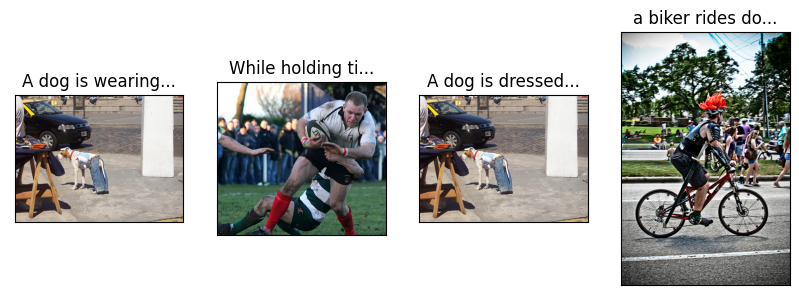

In [ ]:
sample = test_dataset.sample(4, random_state=RANDOM_STATE)
image_examples(sample['image'], sample['query_text'], test_images_path)

## Исследовательский анализ данных


Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Проясним что значит "идентификатор описания в формате `<имя файла изображения>#<порядковый номер описания>`".

In [ ]:
train_dataset[train_dataset['image'] == '1056338697_4f7d7ce270.jpg'].head()

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
27  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
31  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...  
22    A man sleeps under a blanket on a city street .  
27  A woman plays with long red ribbons in an empt...  
31         Chinese market street in the winter time .

In [ ]:
train_dataset[train_dataset['query_id'] == '2549968784_39bfbe44f9.jpg#2'].head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

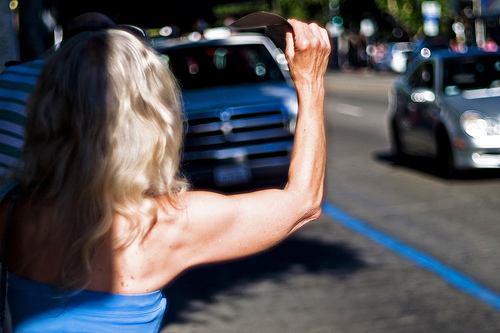

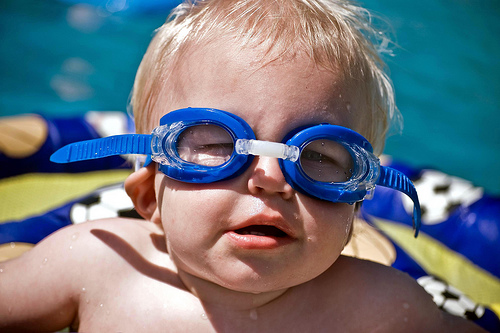

In [ ]:
display(Image.open(os.path.join(train_images_path, '1056338697_4f7d7ce270.jpg')))
display(Image.open(os.path.join(train_images_path, '2549968784_39bfbe44f9.jpg')))

Описание у второго файла подходит, а к первому нет. Следовательно "идентификатор описания" содержит имя файла к которому описание принадлежало изначально.

Узнаем как соотносятся размер и содержимое датасетов что бы объеденить их.

In [ ]:
print(train_dataset.shape[0])
print(crowd_annotations.shape[0])
print(expert_annotations.shape[0])
print(test_dataset.shape[0])

5822
47830
5822
500


In [ ]:
train_dataset['query_id'].unique().shape[0], train_dataset['query_text'].unique().shape[0]

(977, 977)

In [ ]:
train_dataset['image'].unique().shape[0]

1000

In [ ]:
expert_not_anotated = set(train_dataset['image'].value_counts().index.to_list()) ^ set(train_dataset['query_id'].str[:-2].unique())
len(expert_not_anotated), expert_not_anotated

(23,
 {'1343426964_cde3fb54e8.jpg',
  '2054869561_ff723e9eab.jpg',
  '2194494220_bb2178832c.jpg',
  '223299142_521aedf9e7.jpg',
  '2431832075_00aa1a4457.jpg',
  '2479162876_a5ce3306af.jpg',
  '2482629385_f370b290d1.jpg',
  '2806710650_e201acd913.jpg',
  '2913965136_2d00136697.jpg',
  '3015863181_92ff43f4d8.jpg',
  '3019842612_8501c1791e.jpg',
  '3116769029_f5a76f04ba.jpg',
  '3149919755_f9272b10b3.jpg',
  '3185371756_ff4e9fa8a6.jpg',
  '3203453897_6317aac6ff.jpg',
  '3349451628_4249a21c8f.jpg',
  '3375549004_beee810e60.jpg',
  '3387542157_81bfd00072.jpg',
  '3427118504_93126c83e0.jpg',
  '3499720588_c32590108e.jpg',
  '3521374954_37371b49a4.jpg',
  '3523559027_a65619a34b.jpg',
  '86412576_c53392ef80.jpg'})

In [ ]:
train_dataset[train_dataset['image'] == '1343426964_cde3fb54e8.jpg']

image                     query_id  \
914   1343426964_cde3fb54e8.jpg  3741827382_71e93298d0.jpg#2   
1451  1343426964_cde3fb54e8.jpg  2450299735_62c095f40e.jpg#2   
1457  1343426964_cde3fb54e8.jpg  2707873672_15e6b5d54b.jpg#2   
1460  1343426964_cde3fb54e8.jpg   300550441_f44ec3701a.jpg#2   
1462  1343426964_cde3fb54e8.jpg  3213992947_3f3f967a9f.jpg#2   
1478  1343426964_cde3fb54e8.jpg  3234115903_f4dfc8fc75.jpg#2   
1486  1343426964_cde3fb54e8.jpg   416960865_048fd3f294.jpg#2   
1489  1343426964_cde3fb54e8.jpg   522063319_33827f1627.jpg#2   

                                             query_text  
914   A young boy jumps around on a blue mat with a ...  
1451  A little girl in a white shirt sliding down a ...  
1457  Two redheaded boys in brown shirts stand on a ...  
1460  A woman with a scarf on her head walks down a ...  
1462  A woman in a red coat is smiling , while peopl...  
1478  Two women with blue and white uniforms playing...  
1486  A person wearing a red jacket and helmet walks...  
1489     Two children kneeling down with pirate hats on

In [ ]:
train_dataset[train_dataset['query_id'] == '1343426964_cde3fb54e8.jpg#2']

Empty DataFrame
Columns: [image, query_id, query_text]
Index: []

In [ ]:
expert_annotations['image'].unique().shape[0]

1000

In [ ]:
expert_annotations['query_id'].unique().shape[0]

977

Для 23 изображений нет их собственных описаний от экспертов, они отданы другим изображениям.

In [ ]:
crowd_annotations['image'].unique().shape[0]

1000

In [ ]:
crowd_annotations['query_id'].unique().shape[0]

1000

От краудсорсинга есть собственные описания для всех изображений.

За оценку в `crowd_annotations` примим `ratio`. Сделаем общую оценку для `expert_annotations`. Сделаем это с помощью среднего и разделим на 4 что бы оценка была в диапазоне от 0 до 1.

In [ ]:
expert_annotations['score'] = expert_annotations.apply(
    lambda row: (((row['score_1'] + row['score_2'] + row['score_3']) / 3) - 1) / 3,
    axis=1
)
display(expert_annotations['score'].describe())
display(expert_annotations.head(10))

count    5822.000000
mean        0.215886
std         0.268735
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
Name: score, dtype: float64

image                     query_id  score_1  score_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2        1        1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2        1        1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2        1        1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2        1        1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2        2        2   

   score_3     score  
0        1  0.000000  
1        2  0.111111  
2        2  0.111111  
3        2  0.222222  
4        2  0.111111  
5        1  0.000000  
6        1  0.000000  
7        2  0.111111  
8        1  0.000000  
9        2  0.333333

Объеденим данные.

In [ ]:
train_cdf = crowd_annotations.merge(
    expert_annotations, on=['image', 'query_id'], how='outer'
)[['image', 'query_id', 'ratio', 'score', ]]
train_cdf.describe()

ratio        score
count  47830.000000  5822.000000
mean       0.068786     0.215886
std        0.207532     0.268735
min        0.000000     0.000000
25%        0.000000     0.000000
50%        0.000000     0.111111
75%        0.000000     0.333333
max        1.000000     1.000000

Рассчитаем единую оценку от экспертов и краудсорсинга

In [ ]:
def calc_common_score(row):
    if not pd.isna(row['ratio']) and not pd.isna(row['score']):
        row['common_score'] = row['ratio']*0.60 + row['score']*0.40
    elif pd.isna(row['ratio']):
        row['common_score'] = row['score']
    elif pd.isna(row['score']):
        row['common_score'] = row['ratio']
    return row

train_cdf = train_cdf.apply(calc_common_score, axis=1)
train_cdf

image                     query_id  ratio  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    0.0   
...                          ...                          ...    ...   
51318   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2    NaN   
51319   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2    NaN   
51320   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2    NaN   
51321   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2    NaN   
51322   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2    NaN   

          score  common_score  
0           NaN      1.000000  
1           NaN      0.000000  
2           NaN      0.000000  
3           NaN      0.000000  
4           NaN      0.000000  
...         ...           ...  
51318  0.111111      0.111111  
51319  0.111111      0.111111  
51320  0.000000      0.000000  
51321  0.000000      0.000000  
51322  0.000000      0.000000  

[51323 rows x 5 columns]

In [ ]:
train_cdf['common_score'].describe()

count    51323.000000
mean         0.074024
std          0.204389
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: common_score, dtype: float64

Возьмём пары идентификатор описания и описание

In [ ]:
pairs = train_dataset.groupby(['query_id', 'query_text']).size().reset_index().drop(0, axis=1)
pairs

query_id  \
0    1056338697_4f7d7ce270.jpg#2   
1     106490881_5a2dd9b7bd.jpg#2   
2    1082379191_ec1e53f996.jpg#2   
3    1084040636_97d9633581.jpg#2   
4    1096395242_fc69f0ae5a.jpg#2   
..                           ...   
972   929679367_ff8c7df2ee.jpg#2   
973    96420612_feb18fc6c6.jpg#2   
974   968081289_cdba83ce2e.jpg#2   
975   979383193_0a542a059d.jpg#2   
976   997722733_0cb5439472.jpg#2   

                                            query_text  
0    A woman is signaling is to traffic , as seen f...  
1    A young boy in swimming trunks is walking with...  
2                A man and a woman sitting on a dock .  
3             A white dog has its head on the ground .  
4    A young boy with his foot outstretched aims a ...  
..                                                 ...  
972  A puppy is playing with a tennis ball on a wel...  
973  A man with a wake-board is diving over a surfa...  
974     Two boys jumping off the pier into the water .  
975  Six children , all with black hair , sit at a ...  
976  A person in a red shirt climbing up a rock fac...  

[977 rows x 2 columns]

Присвоим всем парам оценки

In [ ]:
df = train_cdf.merge(pairs, on='query_id', how='outer').drop(['ratio', 'score'], axis=1)
df.head(10)

image                     query_id  common_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
3  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
4  2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
5  2934359101_cdf57442dc.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
6  2981702521_2459f2c1c4.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
7   311146855_0b65fdb169.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
8  3197981073_3156963446.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
9  3218480482_66af7587c8.jpg  1056338697_4f7d7ce270.jpg#2           0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1  A woman is signaling is to traffic , as seen f...  
2  A woman is signaling is to traffic , as seen f...  
3  A woman is signaling is to traffic , as seen f...  
4  A woman is signaling is to traffic , as seen f...  
5  A woman is signaling is to traffic , as seen f...  
6  A woman is signaling is to traffic , as seen f...  
7  A woman is signaling is to traffic , as seen f...  
8  A woman is signaling is to traffic , as seen f...  
9  A woman is signaling is to traffic , as seen f...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   common_score  51323 non-null  float64
 3   query_text    50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


Удалим пропуски и дубликаты

In [ ]:
cdf = df.dropna().drop_duplicates()
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         50214 non-null  object 
 1   query_id      50214 non-null  object 
 2   common_score  50214 non-null  float64
 3   query_text    50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


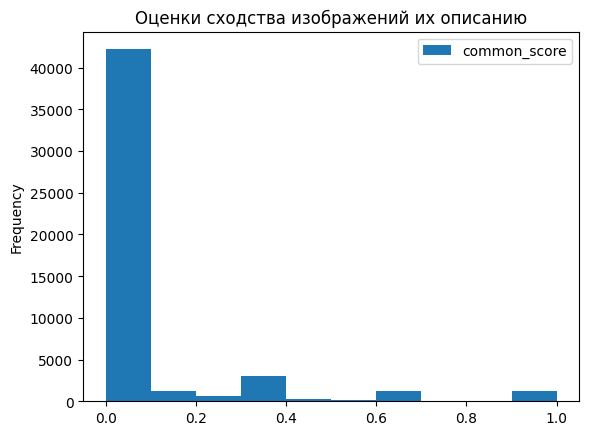

In [ ]:
cdf.plot(kind='hist').set_title('Оценки сходства изображений их описанию');

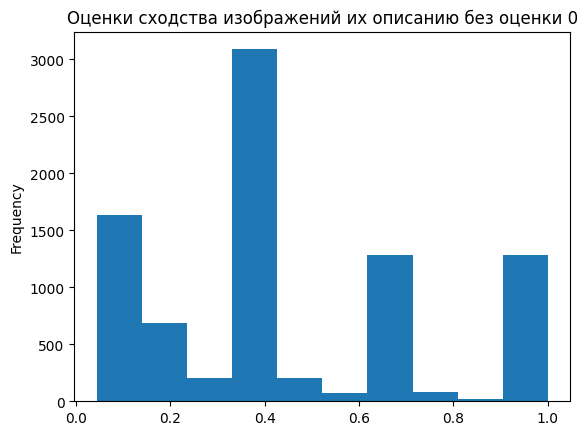

In [ ]:
cdf[cdf['common_score'] != 0]['common_score'].plot(kind='hist').set_title('Оценки сходства изображений их описанию без оценки 0');

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
lemmatizer = WordNetLemmatizer()

Убираем стоп слова

In [ ]:
def lemm_and_drop_stopwords(cell):
    cell = [lemmatizer.lemmatize(word) for word in cell]
    return filter(lambda y: y not in stopwords.words('english'), cell)

df_poc = pairs['query_text'].str.lower().str.findall('\w+') \
    .apply(lemm_and_drop_stopwords).str.join(' ')
df_poc

0                    woman signaling traffic seen behind
1      young boy swimming trunk walking arm outstretc...
2                                 man woman sitting dock
3                               white dog ha head ground
4      young boy foot outstretched aim toy camera fro...
                             ...                        
972    puppy playing tennis ball well kept path lined...
973                  man wake board diving surface water
974                           two boy jumping pier water
975               six child black hair sit table picture
976    person red shirt climbing rock face covered as...
Name: query_text, Length: 977, dtype: object

In [ ]:
for_poc = pd.Series(df_poc.str.cat().split(' ')).value_counts()
for_poc

dog              168
girl              85
boy               76
white             76
wearing           70
                ... 
opening            1
mat                1
baseballwoman      1
braid              1
settingbrown       1
Length: 1937, dtype: int64

Посмотрим на слова которые могут вообще встретится в датасете, отсортированные по частоте встречаемости в текстах, и выберем из них те что не разрешены PoC

In [ ]:
str(list(for_poc.index))

"['dog', 'girl', 'boy', 'white', 'wearing', 'black', 'red', 'blue', 'child', 'playing', 'woman', 'jump', 'standing', 'man', 'people', 'play', 'front', 'running', 'shirt', 'sitting', 'stand', 'jumping', 'green', 'ball', 'run', 'holding', 'water', 'brown', 'walk', 'near', 'men', 'one', 'riding', 'another', 'walking', 'next', 'player', 'jacket', 'beach', 'two', 'yellow', 'air', 'small', 'look', 'rock', 'dirt', 'top', 'field', 'little', 'bike', 'sits', 'dressed', 'large', 'pink', 'hat', 'snow', 'short', 'hair', 'camera', 'ha', 'ride', 'basketball', 'car', 'orange', 'purple', 'street', 'around', 'wooden', 'climb', 'face', 'young', 'along', 'catch', 'uniform', 'back', 'something', 'swing', 'grass', 'looking', 'together', 'crowd', 'leap', 'baby', 'trick', 'tennis', 'striped', 'beside', 'swimming', 'hold', 'carrying', 'posing', 'outdoor', 'across', 'take', 'grassy', 'sit', 'helmet', 'stick', 'head', 'bicycle', 'city', 'hand', 'mountain', 'table', 'high', 'snowy', 'arm', 'river', 'towards', 'ou

Выберим нужные слова

In [ ]:
banned_words = ['girl', 'boy', 'child', 'young', 'baby', 'kid']
banned_words

['girl', 'boy', 'child', 'young', 'baby', 'kid']

Как пример, можно искать синонимы автоматически, что бы не искать похожие слова среди 2000 слов вручную. Будем считать что нашего набора уже достаточно.

In [ ]:
wordnet.synset(banned_words[2]+'.n.01').lemma_names()
# так же подошёл бы PyDictionary

['child',
 'kid',
 'youngster',
 'minor',
 'shaver',
 'nipper',
 'small_fry',
 'tiddler',
 'tike',
 'tyke',
 'fry',
 'nestling']

In [ ]:
cdf[cdf['query_text'].str.contains('mess', regex=False, case=False, na=False)][cdf.common_score > 0]

C:\Users\dimka\AppData\Local\Temp\ipykernel_14136\1453384154.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdf[cdf['query_text'].str.contains('mess', regex=False, case=False, na=False)][cdf.common_score > 0]


image                     query_id  common_score  \
3781   2128119486_4407061c40.jpg  2675685200_0913d84d9b.jpg#2      0.333333   
3791   2675685200_0913d84d9b.jpg  2675685200_0913d84d9b.jpg#2      1.000000   
3792   2706766641_a9df81969d.jpg  2675685200_0913d84d9b.jpg#2      0.622222   
3809   2522297487_57edf117f7.jpg  2675685200_0913d84d9b.jpg#2      0.222222   
3810   2621415349_ef1a7e73be.jpg  2675685200_0913d84d9b.jpg#2      0.111111   
33438  2647049174_0fb47cee2e.jpg  2706766641_a9df81969d.jpg#2      0.333333   
33440  2861932486_52befd8592.jpg  2706766641_a9df81969d.jpg#2      0.088889   
47813   113678030_87a6a6e42e.jpg  3516825206_5750824874.jpg#2      0.111111   
47815  2049051050_20359a434a.jpg  3516825206_5750824874.jpg#2      0.333333   
47820   509123893_07b8ea82a9.jpg  3516825206_5750824874.jpg#2      0.111111   
47821   700884207_d3ec546494.jpg  3516825206_5750824874.jpg#2      0.111111   
47822   732468337_a37075225e.jpg  3516825206_5750824874.jpg#2      0.333333   

                                              query_text  
3781   a young boy making a big mess on the floor and...  
3791   a young boy making a big mess on the floor and...  
3792   a young boy making a big mess on the floor and...  
3809   a young boy making a big mess on the floor and...  
3810   a young boy making a big mess on the floor and...  
33438  A little boy with a mess all over his face and...  
33440  A little boy with a mess all over his face and...  
47813  Laying on stones , a girl with messy hair has ...  
47815  Laying on stones , a girl with messy hair has ...  
47820  Laying on stones , a girl with messy hair has ...  
47821  Laying on stones , a girl with messy hair has ...  
47822  Laying on stones , a girl with messy hair has ...

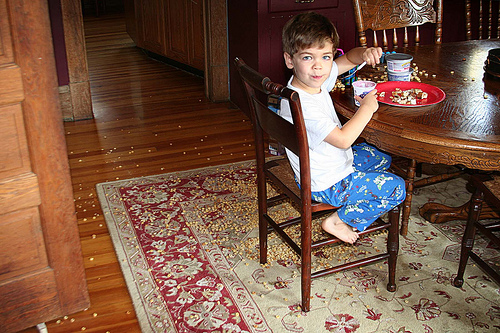

In [ ]:
display(Image.open(train_images_path + '/2675685200_0913d84d9b.jpg'))

Удаляем изображения из обучающей выборки

In [ ]:
def delete_stop_words(df):
    """
    Удаление строк содержащих запрещённые слова в колонке 'query_text'
    (в данном случае исключаются и все запрещённые изображения относящиеся к этому
    описанию, так что отбирать изображения по именам файлов отдельно не нужно)
    """

    for word in banned_words:
        df = df[~df['query_text'].str.contains(word, regex=False, case=False, na=False)]

    return df


In [ ]:
final_cdf = delete_stop_words(cdf).reset_index(drop=True)
final_cdf.head(10)

image                     query_id  common_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
3  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
4  2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
5  2934359101_cdf57442dc.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
6  2981702521_2459f2c1c4.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
7   311146855_0b65fdb169.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
8  3197981073_3156963446.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
9  3218480482_66af7587c8.jpg  1056338697_4f7d7ce270.jpg#2           0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1  A woman is signaling is to traffic , as seen f...  
2  A woman is signaling is to traffic , as seen f...  
3  A woman is signaling is to traffic , as seen f...  
4  A woman is signaling is to traffic , as seen f...  
5  A woman is signaling is to traffic , as seen f...  
6  A woman is signaling is to traffic , as seen f...  
7  A woman is signaling is to traffic , as seen f...  
8  A woman is signaling is to traffic , as seen f...  
9  A woman is signaling is to traffic , as seen f...

In [ ]:
final_cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35562 entries, 0 to 35561
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         35562 non-null  object 
 1   query_id      35562 non-null  object 
 2   common_score  35562 non-null  float64
 3   query_text    35562 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


### Вывод

- Подготовлен обучающий датасет из 35562 пар изображение и описание, оценки их сходства и идентификатора описания
- Исключены строки с подстроками: 'girl', 'boy', 'child', 'young', 'baby', 'kid'

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
img_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255,
)
img = img_datagen.flow_from_dataframe(
    dataframe=final_cdf,
    directory=train_images_path,
    x_col='image',
    y_col='score',
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=False,
    seed=RANDOM_STATE,
)

Found 35562 validated image filenames.


In [ ]:
final_cdf.head()

image                     query_id  common_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
3  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2           0.0   
4  2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2           0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1  A woman is signaling is to traffic , as seen f...  
2  A woman is signaling is to traffic , as seen f...  
3  A woman is signaling is to traffic , as seen f...  
4  A woman is signaling is to traffic , as seen f...

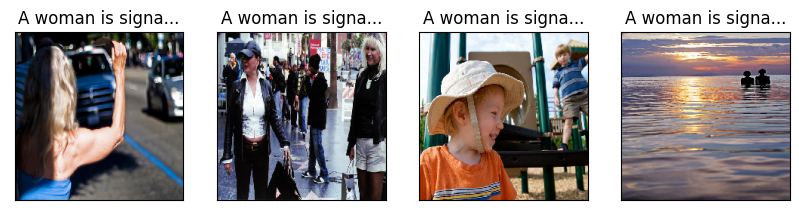

In [ ]:
ex_imgs = final_cdf.head(4)

fig = plt.figure(figsize=(10, 4))
for i in range(ex_imgs.shape[0]):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(img[0][0][i])
    plt.title(ex_imgs['query_text'].iloc[i][:16]+'...')
    plt.xticks([])
    plt.yticks([])
plt.show();

In [ ]:
def get_image_embeddings(images):
    model = Sequential()

    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,
    )

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mse', optimizer=Adam(0.001), metrics='mae')

    return model.predict(images)

In [ ]:
images_vector = get_image_embeddings(img)
images_vector.shape

1112/1112 [==============================] - 1567s 1s/step


(35562, 2048)

### Вывод

- Векторизировали изображения обучающей выборки

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
bert_preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_tiny_en_uncased')
bert_backbone = keras_nlp.models.BertBackbone.from_preset('bert_tiny_en_uncased')

In [ ]:
def get_text_embeddings(texts):
    embeddings = []
    tokens = bert_preprocessor(texts)

    batch_size=32

    for i in tqdm(range(tokens['token_ids'].shape[0] // batch_size + 1)):
        batch = {
            'token_ids': tokens['token_ids'][batch_size*i:batch_size*(i+1)],
            'segment_ids': tokens['segment_ids'][batch_size*i:batch_size*(i+1)],
            'padding_mask': tokens['padding_mask'][batch_size*i:batch_size*(i+1)]
        }

        # Используем модель. Получаем эмбеддинги
        batch_embeddings = bert_backbone.predict(batch, verbose=0)

        embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [ ]:
texts_vector = get_text_embeddings(final_cdf['query_text'])
texts_vector.shape

100%|██████████| 1112/1112 [09:19<00:00,  1.99it/s]


(35562, 128)

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
images_vector.shape, texts_vector.shape

((35562, 2048), (35562, 128))

In [ ]:
features = np.concatenate([pd.DataFrame(images_vector), pd.DataFrame(texts_vector)], axis=1)
features.shape

(35562, 2176)

In [ ]:
target = final_cdf['common_score'].reset_index(drop=True)
target.shape

(35562,)

## Обучение модели предсказания соответствия


Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```python
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Используем знания отсюда  
https://keras.io/examples/vision/nl_image_search/

In [ ]:
groups = final_cdf['image']

gss = GroupShuffleSplit(n_splits=1, train_size=.6, random_state=RANDOM_STATE)
train_indices, valid_indices = next(gss.split(X=features, y=target, groups=groups))
len(train_indices), len(valid_indices)

(21024, 14538)

In [ ]:
features.shape, target.shape, final_cdf.shape

((35562, 2176), (35562,), (35562, 4))

In [ ]:
features_train, features_valid = features[train_indices], features[valid_indices]
target_train, target_valid = target[train_indices], target[valid_indices]

In [ ]:
print('Максимум в выборках', features_train.max(), features_valid.max())
print('Минимум в выборках', features_train.min(), features_valid.min())
print('Среднее в выборках', features_train.mean(), features_valid.mean())
print('Стандартное отклонение в выборках', features_train.std(), features_valid.std())

Максимум в выборках 14.995386 15.30311
Минимум в выборках -1.0 -1.0
Среднее в выборках 0.10511827 0.10584366
Стандартное отклонение в выборках 0.66043603 0.6618054


Нормализация значений

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

### Константная модель

In [ ]:
predictions = pd.Series(target_train.mean(), index=target_valid.index)
predictions.head()

0    0.085817
1    0.085817
2    0.085817
6    0.085817
8    0.085817
dtype: float64

In [ ]:
np.sqrt(mean_squared_error(target_valid, predictions))

0.21503827174065587

### LinearRegression

In [ ]:
model_lr = LinearRegression().fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
np.sqrt(mean_squared_error(target_valid, predictions))

15761.778113650718

### Своя модель

In [ ]:
my_model_nn = Sequential()
my_model_nn.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],)))
my_model_nn.add(BatchNormalization())
my_model_nn.add(Dense(512, activation='tanh'))
my_model_nn.add(Dropout(0.2))
my_model_nn.add(Dense(256, activation='relu'))
my_model_nn.add(BatchNormalization())
my_model_nn.add(Dense(128, activation='relu'))
my_model_nn.add(BatchNormalization())
my_model_nn.add(Dense(64, activation='relu'))
my_model_nn.add(Flatten())
my_model_nn.add(Dense(1, activation='linear'))


my_model_nn.compile(loss='mean_squared_error',
                    # optimizer = Adam(lr=0.0001),
                    optimizer = Adam(lr=0.001),
                    metrics=[RootMeanSquaredError()])

c:\Users\dimka\.conda\envs\ds_practicum_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


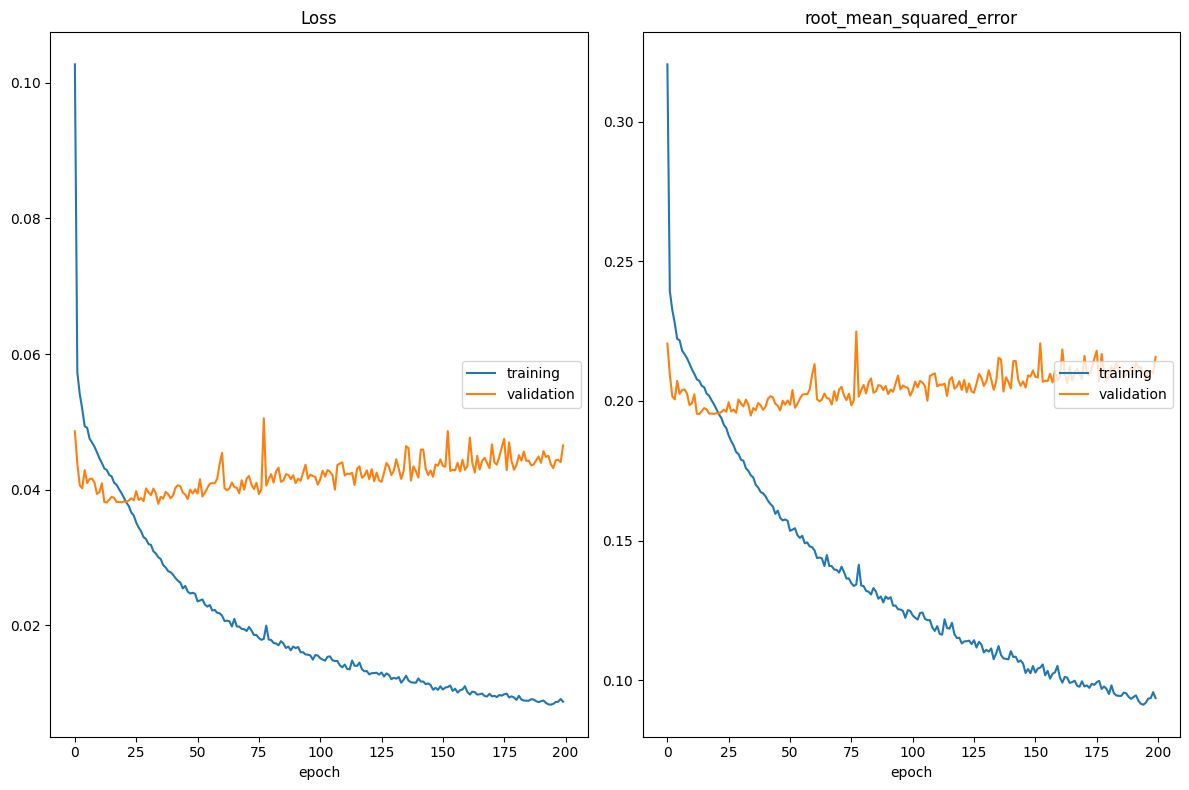

Loss
	training         	 (min:    0.008, max:    0.103, cur:    0.009)
	validation       	 (min:    0.038, max:    0.051, cur:    0.047)
root_mean_squared_error
	training         	 (min:    0.091, max:    0.320, cur:    0.094)
	validation       	 (min:    0.195, max:    0.225, cur:    0.216)
657/657 - 8s - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2158 - 8s/epoch - 12ms/step


In [ ]:
my_model_nn.fit(features_train,
                target_train,
                epochs=200,
                batch_size=32,
                validation_data=(features_valid, target_valid),
                validation_steps = math.ceil(features_train.shape[1]/32),
                verbose=2,
                callbacks=[PlotLossesKeras()])

### Вывод

Лучшей оказалась собственная полносвязная нейросеть с RMSE **0.0541**. Выбираем её для тестирования

## Тестирование модели

- Настало время протестировать модель.
- Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`,
- выберите случайные 10 запросов из файла `test_queries.csv` и
- для каждого запроса выведите наиболее релевантное изображение.
- Сравните визуально качество поиска.

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1/255
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='image',
    y_col='query_text',
    directory=test_images_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=False,
    seed=RANDOM_STATE
)

Found 500 validated image filenames.


In [ ]:
images_vector_test = get_image_embeddings(test_images)

16/16 [==============================] - 23s 1s/step


In [ ]:
inference_dataset = test_dataset.sample(10, random_state=RANDOM_STATE)
inference_dataset

query_id  \
272  3211199368_ca78387f72.jpg#2   
244  3142055158_01b9e4caa4.jpg#4   
271  3211199368_ca78387f72.jpg#1   
381  3517023411_a8fbd15230.jpg#1   
52   1991806812_065f747689.jpg#2   
48    191003283_992257f835.jpg#3   
299  3351418768_596ef7fd6f.jpg#4   
452   607339469_af851c4119.jpg#2   
295  3351418768_596ef7fd6f.jpg#0   
85   2346402952_e47d0065b6.jpg#0   

                                            query_text  \
272  A dog is wearing jeans and a blue and yellow s...   
244  While holding tight to the ball , the man in r...   
271  A dog is dressed in a shirt and pants on the s...   
381                    a biker rides down the street .   
52                      a kickboxer jumping for a kick   
48   A young boy wearing a red shirt stands in the ...   
299  A woman in purple with two children in the mou...   
452  A little girl dressed in a pink shirt , blue s...   
295  a family standing in a rock cave with some of ...   
85   Three people are looking into photographic equ...   

                         image  
272  3211199368_ca78387f72.jpg  
244  3142055158_01b9e4caa4.jpg  
271  3211199368_ca78387f72.jpg  
381  3517023411_a8fbd15230.jpg  
52   1991806812_065f747689.jpg  
48    191003283_992257f835.jpg  
299  3351418768_596ef7fd6f.jpg  
452   607339469_af851c4119.jpg  
295  3351418768_596ef7fd6f.jpg  
85   2346402952_e47d0065b6.jpg

100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


16/16 [==============================] - 0s 4ms/step


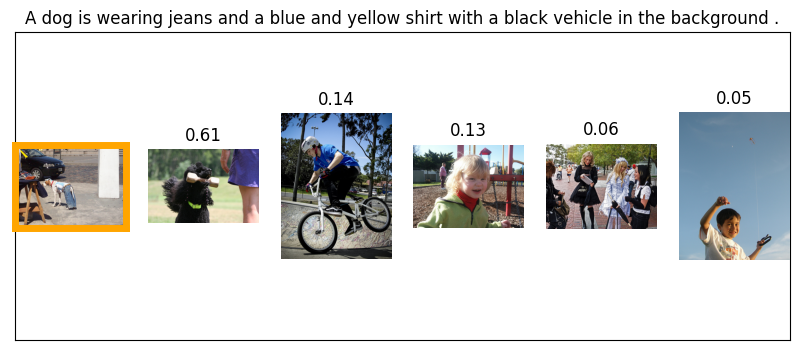

100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

16/16 [==============================] - 0s 4ms/step


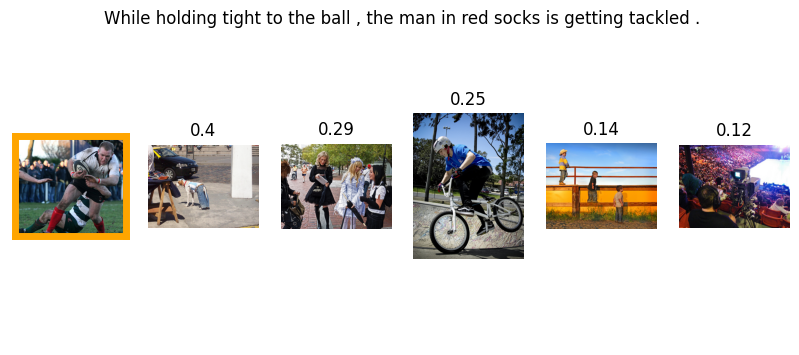

100%|██████████| 1/1 [00:00<00:00, 13.19it/s]

16/16 [==============================] - 0s 4ms/step


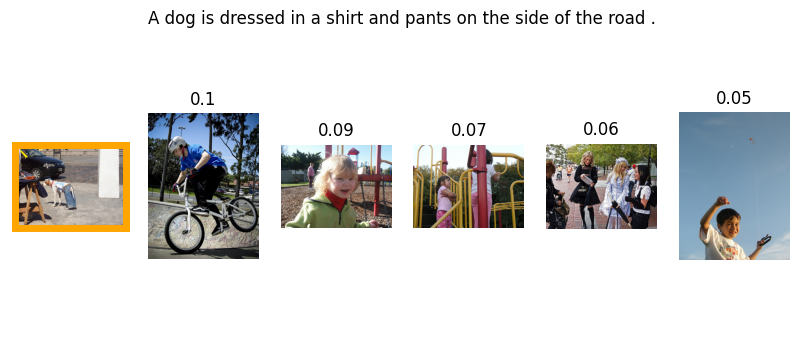

100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

14/16 [=========================>....] - ETA: 0s

16/16 [==============================] - 0s 4ms/step


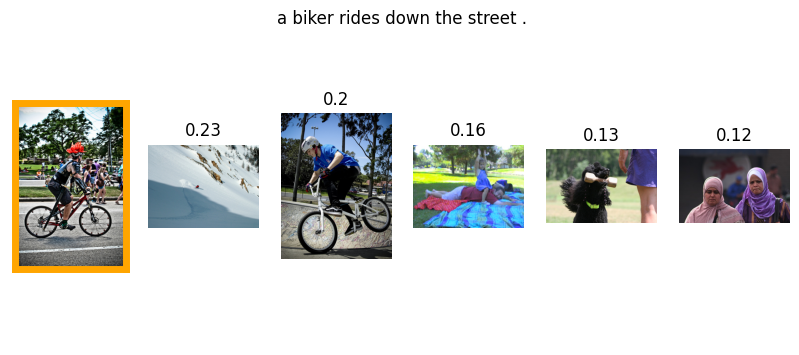

100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

13/16 [=======================>......] - ETA: 0s

16/16 [==============================] - 0s 4ms/step


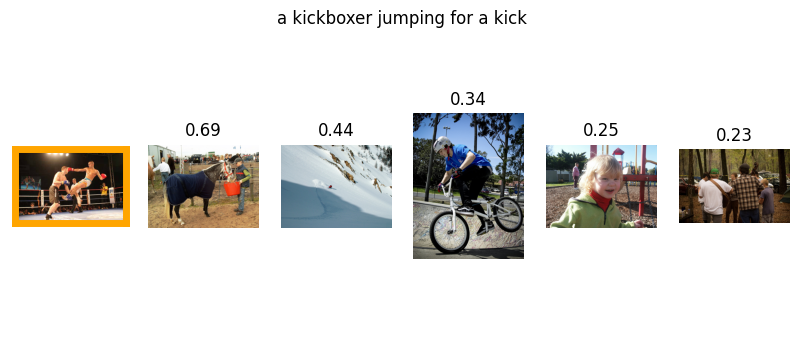

❗ This image is unavailable in your country in compliance with local laws ❗

❗ This image is unavailable in your country in compliance with local laws ❗

❗ This image is unavailable in your country in compliance with local laws ❗

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

16/16 [==============================] - 0s 5ms/step


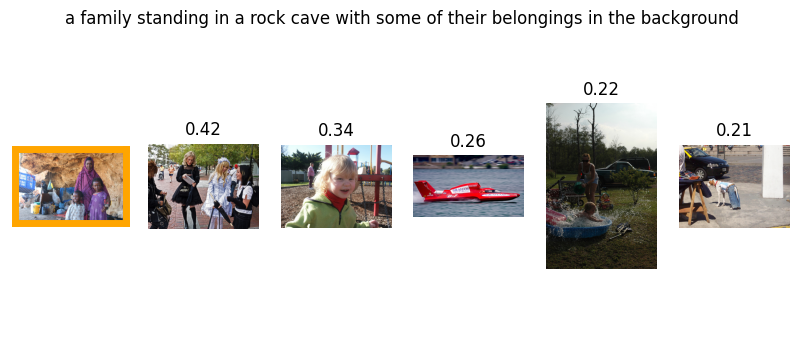

100%|██████████| 1/1 [00:00<00:00, 12.85it/s]

12/16 [=====================>........] - ETA: 0s

16/16 [==============================] - 0s 5ms/step


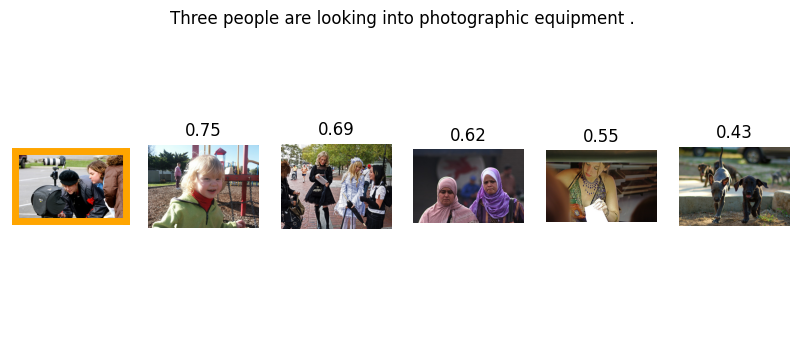

In [ ]:
def get_inference(row):
    # Сколько изображений нужно найти?
    needed_n_imgs = 5

    lower_query = row['query_text'].lower()
    for word in banned_words:
        if word in lower_query:
            display(Markdown('❗ This image is unavailable in your country in compliance with local laws ❗'))
            return row

    text_vector = get_text_embeddings([row['query_text']])
    # Эмбеддинги поискового запроса (повторение одного и того же 500 раз)
    inference_text = np.resize(text_vector, (images_vector_test.shape[0], text_vector.shape[1]))

    # Совмещённый вектор изображений и запроса, применение Scaler
    features_test = scaler.transform(
        np.concatenate([pd.DataFrame(images_vector_test), pd.DataFrame(inference_text)], axis=1)
    )

    # Оценка моделью соответствия для пары изображение-текст
    predicted_score = my_model_nn.predict(features_test)

    xc = np.reshape(predicted_score, (predicted_score.shape[0],))
    result_dataset = pd.concat((test_dataset, pd.Series(xc, name='predictions')), axis=1)
    data = result_dataset.pivot_table(columns='image', values='predictions', aggfunc='mean').T

    # Отбираем 5 самых подходящих изображений по текстовый запрос по версии модели
    top = list(data.sort_values(by='predictions', ascending=False).head(needed_n_imgs).index)
    top_score = list(data.sort_values(by='predictions', ascending=False).head(needed_n_imgs).values.reshape(1, -1)[0])

    # Отрисовка результатов
    fig = plt.figure(figsize=(10, 4))
    plt.title(row['query_text'])
    plt.xticks([])
    plt.yticks([])

    current_image = test_dataset[test_dataset['query_id'] == row['query_id']]['image'].values[0]
    plt.rcParams['axes.edgecolor'] = 'orange'
    plt.rcParams['axes.linewidth'] = needed_n_imgs
    fig.add_subplot(1, needed_n_imgs+1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Image.open(os.path.join(test_images_path, current_image)))


    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0
    for i in range(needed_n_imgs):
        fig.add_subplot(1, needed_n_imgs+1, i+2, title=round(top_score[i], 2))
        plt.imshow(Image.open(os.path.join(test_images_path, top[i])))
        plt.xticks([])
        plt.yticks([])

    plt.show()

# Перебираем 10 запросов
inf = inference_dataset.apply(get_inference, axis=1)

Можно сравнить со всеми изображениями которые могли бы подойти лучше из тестовой выборки

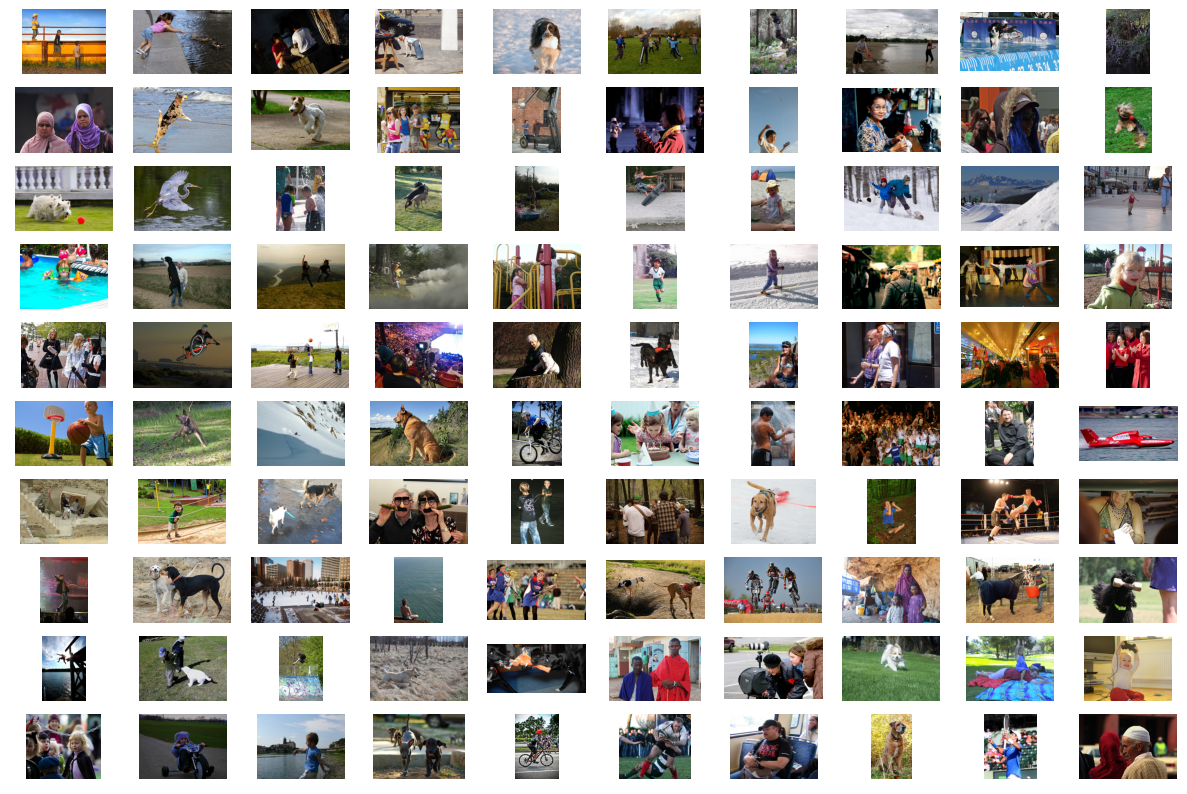

In [ ]:
fig = plt.figure(figsize=(15, 10))
img_files = list(set(test_images.filenames))

for i in range(len(img_files)):
    current_image = img_files[i]
    fig.add_subplot(10, 10, i+1)
    plt.imshow(Image.open(Path(test_images_path, current_image)))
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Предобученные модели для этой задачи которые можно было бы использовать
# ViT (Vision Transformer)
# CLIP (Contrastive Language-Image Pre-Training)
# DALL-E
# VSE++ (Visual Semantic Embedding++)
# DeViSE (Deep Visual-Semantic Embedding Model)

## Выводы

Решалась задача "Совместный поиск на основе изображений и текста (Joint image-text based retrieval)". Нужно было построить модель машинного обучения которая оценивает соответствие содержания изображения и её текстового описания.

Исходными данными послужили
- в обучающей выборке 5822 сочетания изображение-описание и 977 файлов изображений
  - 5822 оценок сходства от экспертов
  - 51323 оценок сходства от краудсорсинга
- в тестовой выборке 500 сочетаний изображение-описание и 100 файлов изображений

Они были обработаны и проанализированы. Оценки были преобразованы в одну собственным алгоритмом. Из обучающей выборки удалены данные запрещённые по условиям задачи обработке компанией, по наличию слов в описании.

По условию задачи выбран только один фреймворк — Keras

Были подготовлены и объеденины вместе эмбеддинги для входа модели, которые в свою очередь получены моделями:
- Для текста `bert_tiny_en_uncased`
- Для изображений `ResNet50` с `backbone` предобученным готовыми весами `imagenet` без последнего слоя

Обучено 3 модели машинного обучения с метрикой RMSE
- Константная модель: 0.2150
- Линейная регрессия: 15761
- Собственная полносвязная: 0.0541

Тестирование модели и визуальная проверка показали  
(на 10 примерах, результаты модели отсортированы по схожести и взяты 5 с самой высокой оценкой схожести)
- находит довольно схожие запросу изображения но далеко не все
- попадаются изображения максимально похожие среди всех
- так же и совсем не похожие